# Impacts of Landuse on Water Flow Peaks
by Martha Burket, Carson DeSotel  
GEOG 5543  
Fall 2021

In [8]:
'''
    Installation:
'''
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install requests

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
'''
    Imports:
'''
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
'''
    Open Saved Data & Validate
'''
final_data = pd.read_csv('final_data.csv')

### Convert Dates column to DateTime type
final_data['Dates'] = pd.to_datetime(final_data['Dates'], utc = True)

# print(df.head(10), df.tail(10))

In [67]:
'''
    Identify Max & Min Values
'''

columns = df.columns[1:] # exclude dates

for col in columns:
    print(col)
    print('Max:', df[col].max())
    print('Min:', df[col].min())
    print('----')

Temp (F)
Max: 0.94
Min: 0.16
----
RH (%)
Max: 1.0
Min: 0.16
----
Wind Spd (mph)
Max: 6.1941707728626325e-09
Min: 0.0
----
Precip (in)
Max: 0.4
Min: 0.0
----
Flow (ft^3 / s)
Max: 0.06922306144272952
Min: 0.0007494042657101236
----
DayOfYear
Max: 274
Min: 91
----


In [68]:
'''
    Normalize Values:
'''

### Normalize RH by dividing by 100 to fit in range [0, 1]
final_data['RH (%)'] = final_data['RH (%)'].apply(lambda x: x / 100)

### Normalize Temp 
final_data['Temp (F)'] = final_data['Temp (F)'].apply(lambda x: x / 100)

### Normalize Precipitation
precip_max = final_data['Precip (in)'].max()
final_data['Precip (in)'] = final_data['Precip (in)'].apply(lambda x: x / precip_max)

### Normalize Wind Speed
wind_max = final_data['Wind Spd (mph)'].max()
final_data['Wind Spd (mph)'] = final_data['Wind Spd (mph)'].apply(lambda x: x / wind_max)

### Normalize Flow using Min-Max Normalization
flow_max = final_data['Flow (ft^3 / s)'].max()
flow_min = final_data['Flow (ft^3 / s)'].min()

final_data['Flow (ft^3 / s)'] = final_data['Flow (ft^3 / s)'].apply(lambda x: (x - flow_min) / (flow_max - flow_min))

                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-01 05:00:00+00:00      0.41    0.95             NaN          0.0   
1 2012-04-01 06:00:00+00:00      0.41    1.00             NaN          0.0   
2 2012-04-01 07:00:00+00:00      0.43    1.00             NaN          0.0   
3 2012-04-01 08:00:00+00:00      0.46    0.92             NaN          0.0   
4 2012-04-01 09:00:00+00:00      0.49    0.86             NaN          0.0   
5 2012-04-01 10:00:00+00:00      0.54    0.77             NaN          0.0   
6 2012-04-01 11:00:00+00:00      0.57    0.74             NaN          0.0   
7 2012-04-01 12:00:00+00:00      0.60    0.66             NaN          0.0   
8 2012-04-01 13:00:00+00:00      0.65    0.58             NaN          0.0   
9 2012-04-01 14:00:00+00:00      0.66    0.58             NaN          0.0   

   Flow (ft^3 / s)  DayOfYear  
0         0.003932         92  
1         0.003823         92  
2         0.003713         92  
3         0.0

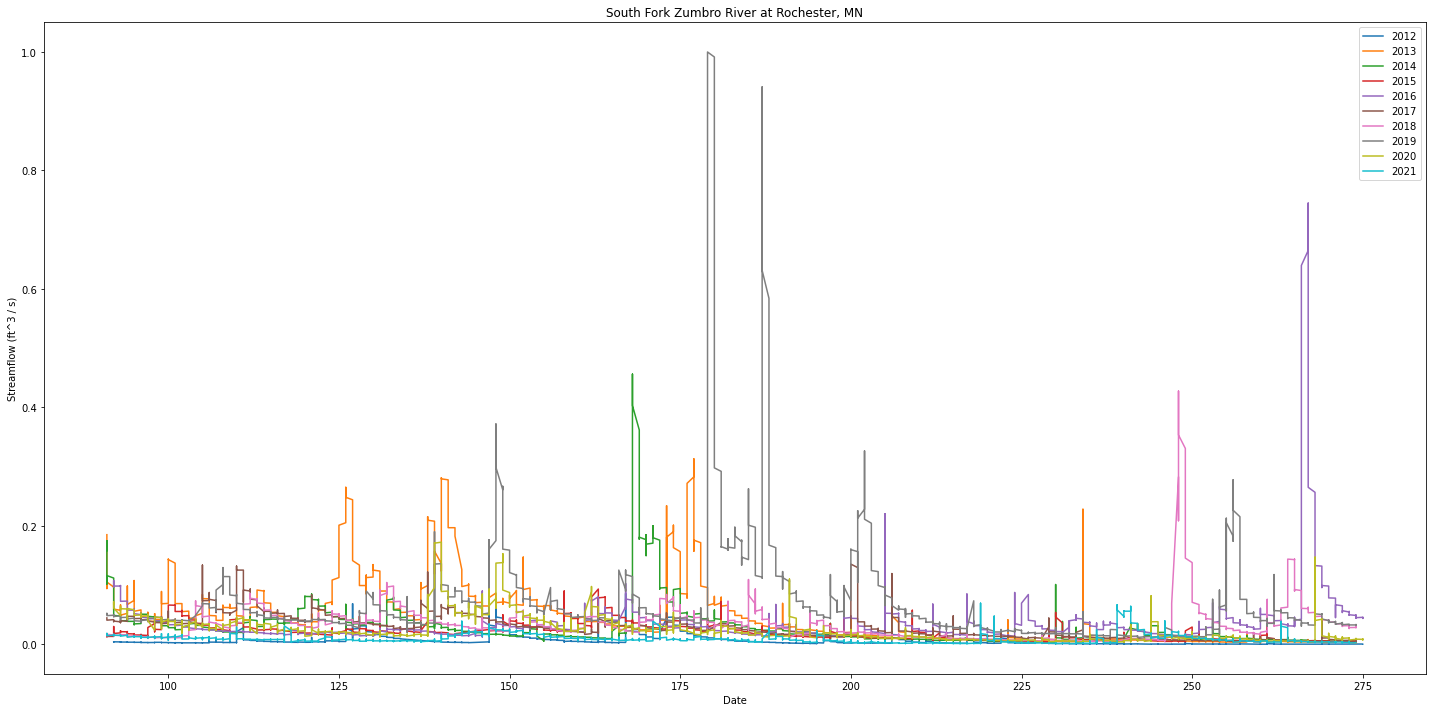

In [63]:
'''
    Plot Normalized Flow
'''

df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Streamflow (ft^3 / s)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Flow (ft^3 / s)'], label=str(2012 + index))
    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()


                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-01 05:00:00+00:00      0.41    0.95             NaN          0.0   
1 2012-04-01 06:00:00+00:00      0.41    1.00             NaN          0.0   
2 2012-04-01 07:00:00+00:00      0.43    1.00             NaN          0.0   
3 2012-04-01 08:00:00+00:00      0.46    0.92             NaN          0.0   
4 2012-04-01 09:00:00+00:00      0.49    0.86             NaN          0.0   
5 2012-04-01 10:00:00+00:00      0.54    0.77             NaN          0.0   
6 2012-04-01 11:00:00+00:00      0.57    0.74             NaN          0.0   
7 2012-04-01 12:00:00+00:00      0.60    0.66             NaN          0.0   
8 2012-04-01 13:00:00+00:00      0.65    0.58             NaN          0.0   
9 2012-04-01 14:00:00+00:00      0.66    0.58             NaN          0.0   

   Flow (ft^3 / s)  DayOfYear  
0         0.003932         92  
1         0.003823         92  
2         0.003713         92  
3         0.0

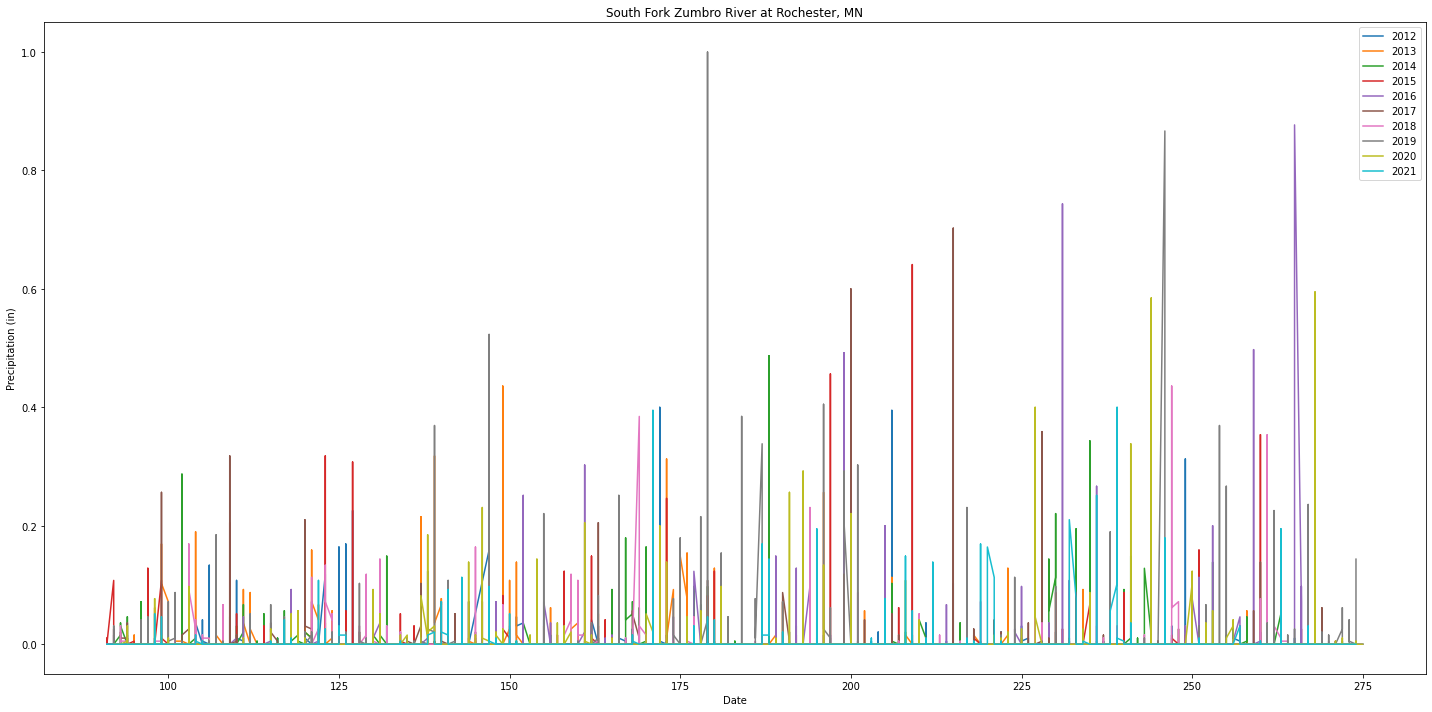

In [54]:
'''
    Display Precipitation
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column'Precip (in)'
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Precip (in)'], label=str(2012 + index))
    
    print(df.head(10))
    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-01 05:00:00+00:00      0.41    0.95             NaN          0.0   
1 2012-04-01 06:00:00+00:00      0.41    1.00             NaN          0.0   
2 2012-04-01 07:00:00+00:00      0.43    1.00             NaN          0.0   
3 2012-04-01 08:00:00+00:00      0.46    0.92             NaN          0.0   
4 2012-04-01 09:00:00+00:00      0.49    0.86             NaN          0.0   
5 2012-04-01 10:00:00+00:00      0.54    0.77             NaN          0.0   
6 2012-04-01 11:00:00+00:00      0.57    0.74             NaN          0.0   
7 2012-04-01 12:00:00+00:00      0.60    0.66             NaN          0.0   
8 2012-04-01 13:00:00+00:00      0.65    0.58             NaN          0.0   
9 2012-04-01 14:00:00+00:00      0.66    0.58             NaN          0.0   

   Flow (ft^3 / s)  DayOfYear  
0         0.003932         92  
1         0.003823         92  
2         0.003713         92  
3         0.0

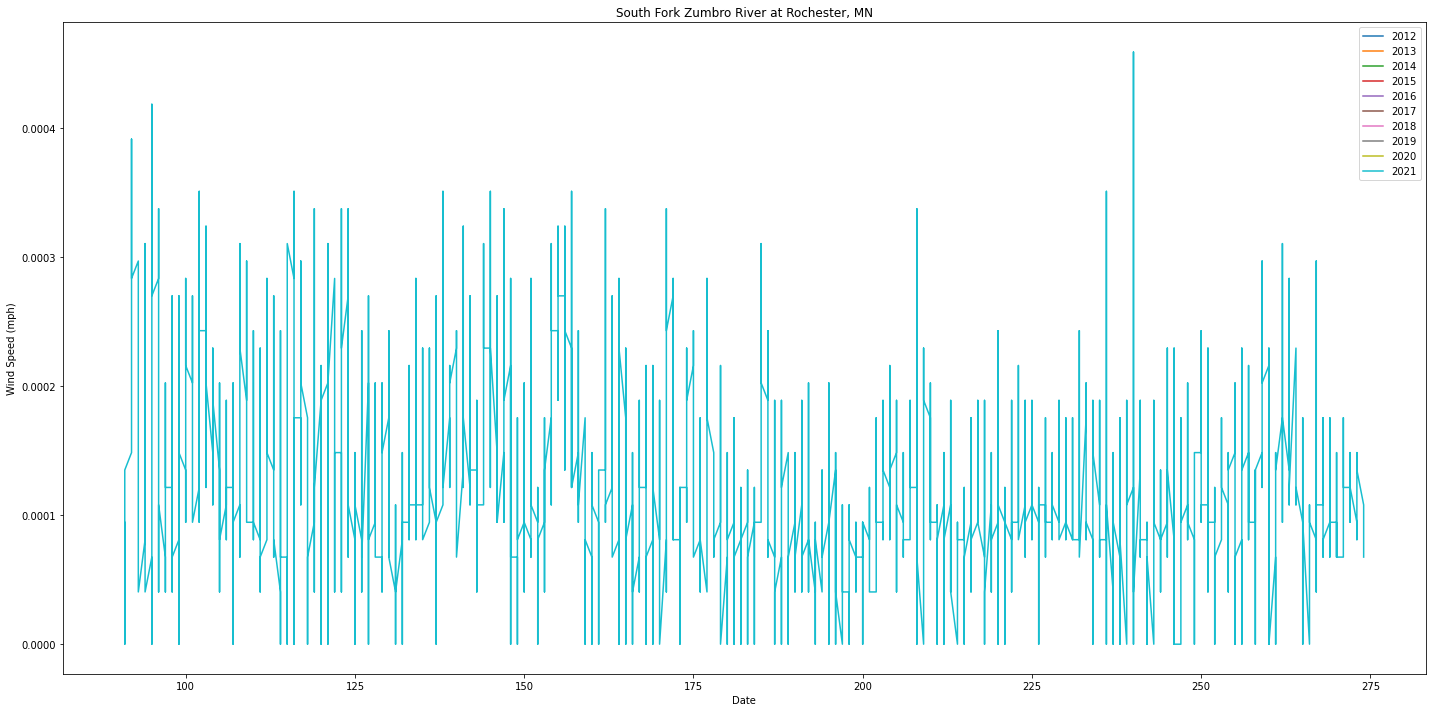

In [47]:
'''
    Display Normalized Wind Speed
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Wind Speed (mph)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Wind Spd (mph)'], label=str(2012 + index))
    
    print(df.head(10))
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

### References
[1] https://www.earthdatascience.org/tutorials/acquire-and-visualize-usgs-hydrology-data/  
[2] https://waterservices.usgs.gov/rest/IV-Service.html  
[3] https://www.ogc.org/standards/waterml  
[4] https://docs.python-requests.org/en/latest/user/quickstart/  
[5] https://www.usgs.gov/special-topic/water-science-school/science/how-streamflow-measured?qt-science_center_objects=0#qt-science_center_objects  
